# User-level graph

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import statsmodels.api as sm
import sqlite3
import os
import re
import seaborn as sns
import matplotlib.pyplot as plt
from networkx.algorithms import bipartite
from itertools import combinations

import warnings
warnings.filterwarnings('ignore')

from utils import ROOTPATH, build_df_year, generate_index
from backbone import disparity_filter

In [2]:
df2013 = build_df_year(2013)
generate_index()

from utils import USERS, SUBREDDITS, user2index, index2user, subr2index, index2subr

building base dataframe for year 2013...
- fetching submissions for year 2013
- fetching comments for year 2013


## basic descriptives
### per-user submissions / subreddits

In [3]:
# visualize distributions 

def plot_user_subr_distribution(dfyear, year):
    user_aggr = dfyear.groupby("author").agg({"subreddit": lambda x: set(list(x))}).reset_index()
    user_aggr["n_subr"] = user_aggr["subreddit"].map(lambda x: len(x))
    plt.hist(user_aggr["n_subr"], bins=15, color="#FF4500")
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("# of subreddits", fontsize=14)
    plt.ylabel("# of users", fontsize=14)
    plt.savefig(ROOTPATH + f"output/fig/user_subreddit_distribution_{year}.svg")
    return user_aggr

def plot_user_subm_distribution(dfyear, year):
    user_aggr = dfyear.groupby("author").agg({"submission_id": lambda x: set(list(x))}).reset_index()
    user_aggr["n_subm"] = user_aggr["submission_id"].map(lambda x: len(x))
    plt.hist(user_aggr["n_subm"], bins=15, color="#FF4500")
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("# of submissions", fontsize=14)
    plt.ylabel("# of users", fontsize=14)
    plt.savefig(ROOTPATH + f"output/fig/user_submission_distribution_{year}.svg")
    return user_aggr

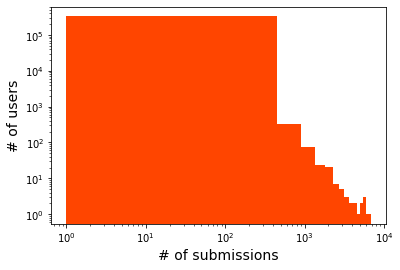

In [4]:
user_aggr_subm2013 = plot_user_subm_distribution(df2013, "2013")

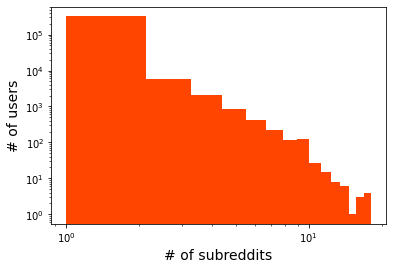

In [5]:
user_aggr_subr2013 = plot_user_subr_distribution(df2013, "2013")

## subsetting: only look at active multi-subreddit users

In [6]:
def subset(user_aggr_submyear, user_aggr_subryear, dfyear):
    ACTIVEUSERS = user_aggr_submyear[user_aggr_submyear["n_subm"]>=10].author.unique()
    MULTICOMMUSERS = user_aggr_subryear[user_aggr_subryear["n_subr"]>=2].author.unique()
    SUBSETUSERS = list(set(ACTIVEUSERS) & set(MULTICOMMUSERS))
    print("subset size:", len(SUBSETUSERS))
    dfyear_subset = dfyear[dfyear["author"].isin(SUBSETUSERS)].copy()
    return dfyear_subset

In [7]:
df2013_subset = subset(user_aggr_subm2013, user_aggr_subr2013, df2013)

subset size: 14778


## build user graph:

- node: user
- link: whether two users co-occur in a submission
    - weight: number of co-occurrences

In [8]:
def build_user_graph(dfyear_subset):
    subm_aggr = dfyear_subset.groupby("submission_id").agg({"author": lambda x: set(list(x))}).reset_index()
    subm_aggr["n_user"] = subm_aggr["author"].map(lambda x: len(x))
    subm_aggr = subm_aggr[subm_aggr["n_user"]>1].reset_index().drop(columns=["index"])  
    
    user_edges = {}
    print("recording edges...")
    for i,row in subm_aggr.iterrows():
        users = list(row["author"])
        if i%10000==0: print(" - progress:", i/len(subm_aggr))
        userpairs = [*combinations(users,2)]
        for i,up in enumerate(userpairs):
            u1 = min(user2index[up[0]],user2index[up[1]])
            u2 = max(user2index[up[0]],user2index[up[1]])
            try:
                user_edges[(u1, u2)] += 1
            except:
                user_edges[(u1, u2)] = 1
                
    print("building graph...")       
    userg = nx.Graph()
    for p,w in user_edges.items():
        userg.add_edge(p[0], p[1], weight=w)
    
    print("graph descriptives:")
    print(" - # of nodes:", len(userg.nodes()))
    print(" - # of edges:", len(userg.edges()))
    return user_edges, userg

In [9]:
user_edges2013, userg2013 = build_user_graph(df2013_subset)

recording edges...
 - progress: 0.0
 - progress: 0.0816199936336405
 - progress: 0.163239987267281
 - progress: 0.24485998090092148
 - progress: 0.326479974534562
 - progress: 0.4080999681682025
 - progress: 0.48971996180184296
 - progress: 0.5713399554354834
 - progress: 0.652959949069124
 - progress: 0.7345799427027645
 - progress: 0.816199936336405
 - progress: 0.8978199299700454
 - progress: 0.9794399236036859
building graph...
graph descriptives:
 - # of nodes: 14726
 - # of edges: 12053951


## EDA

### distribution of degrees, weight and strength

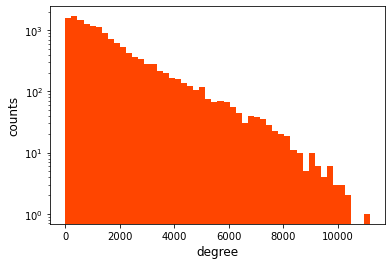

In [10]:
# degree distribution
degrees = [d for n,d in userg2013.degree()]
plt.hist(degrees, color="#FF4500", bins=50)
plt.yscale("log")
plt.xlabel("degree", fontsize=12)
plt.ylabel("counts", fontsize=12)
# plt.show()
plt.savefig(ROOTPATH + f"output/fig/userg_degree_2013.svg")

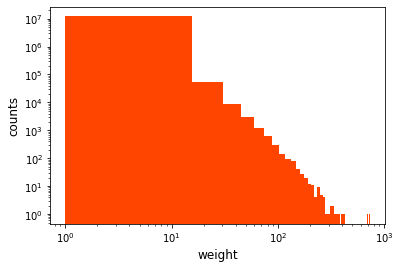

In [11]:
# weight distribution
plt.hist(list(user_edges2013.values()), color="#FF4500", bins=50)
plt.yscale("log")
plt.xscale("log")
plt.xlabel("weight", fontsize=12)
plt.ylabel("counts", fontsize=12)
# plt.show()
plt.savefig(ROOTPATH + f"output/fig/userg_weight_2013.svg")

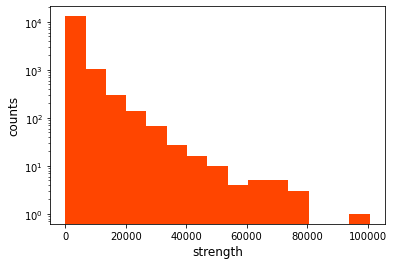

In [12]:
# strength distribution
strengths = [d for n,d in userg2013.degree(weight="weight")]
plt.hist(strengths, bins=15, color="#FF4500")
plt.yscale("log")
# plt.xscale("log")
plt.xlabel("strength", fontsize=12)
plt.ylabel("counts", fontsize=12)
# plt.show()
plt.savefig(ROOTPATH + f"output/fig/userg_strength_2013.svg")

In [13]:
# nx.degree_assortativity_coefficient(userg2012)  
# -0.16842736406012168
# disassortative --> degree heterogeneity

### betweenness: too many links --> need to sparsify the graph

In [14]:
# betweenness --> time complexity O(nm), n = num of nodes, m = num of links
# https://kops.uni-konstanz.de/bitstream/handle/123456789/5739/algorithm.pdf

# needs graph sparsification (fewer links)!

# betws = nx.betweenness_centrality(userg2012)
# plt.hist(betws, color="#FF4500")
# plt.yscale("log")
# # plt.xscale("log")
# plt.xlabel("betweenness", fontsize=12)
# plt.ylabel("counts", fontsize=12)
# # plt.show()
# plt.savefig(ROOTPATH + f"output/fig/userg_betweenness_2012.svg")

## toxicity at node-level

### correlations of attributes

In [15]:
# save node attributes
nodedf = pd.DataFrame()
nodedf["Id"] = [*userg2013.nodes()]
nodedf["author"] = nodedf["Id"].map(lambda x: index2user[x])
nodedf["degree"] = degrees
nodedf["strength"] = strengths
nodedf["strength_logged"] = nodedf["strength"].map(lambda x: np.log(x))
nodedf["degree_logged"] = nodedf["strength"].map(lambda x: np.log(x))

In [16]:
# get toxicity score for individual users
aggr_func = {"toxicity": lambda x: list(x)}
user_toxicity = df2013[["author","toxicity"]][df2013["toxicity"].notna()].groupby("author").agg(aggr_func).reset_index()
nodedf = nodedf.merge(user_toxicity, on="author", how="left")

In [23]:
# nodedf["toxicity"] = nodedf["toxicity"].map(lambda x: [t for t in x if ~np.isnan(t)])
nodedf["mean_tox"] = nodedf["toxicity"].map(lambda x: np.mean(x))
nodedf["max_tox"] = nodedf["toxicity"].map(lambda x: max(x) if str(x)!="nan" else np.NaN)
nodedf["min_tox"] = nodedf["toxicity"].map(lambda x: min(x) if str(x)!="nan" else np.NaN)
nodedf["range_tox"] = nodedf["toxicity"].map(lambda x: max(x)-min(x) if str(x)!="nan" else np.NaN)
nodedf["var_tox"] = nodedf["toxicity"].map(lambda x: np.var(x) if str(x)!="nan" else np.NaN)

In [24]:
# plt.scatter(nodedf["degree"], nodedf["strength"], color="#FF4500", alpha=0.02)
# plt.yscale("log")

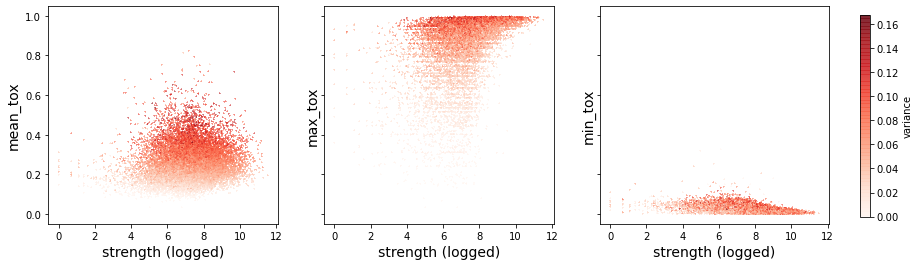

In [27]:
# plot
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(ncols=3, figsize=(14,4), sharex=True, sharey=True)
for i,col in enumerate(["mean_tox", "max_tox", "min_tox"]):
    x = nodedf["strength_logged"]
    y = nodedf[col]
    m,b = np.polyfit(x, y, 1)
    
    # scatterplot
    _ = ax[i].scatter(x, y, cmap="Reds", c=nodedf["var_tox"], alpha=0.6, s=1, marker="+")
    
    # OLS
    ax[i].plot(x, m*x+b, ":", color="grey")
    ax[i].set_xlabel("strength (logged)", fontsize=14)
    ax[i].set_ylabel(col, fontsize=14)
fig.colorbar(_, cax=fig.add_axes([0.93, 0.15, 0.01, 0.7]), label="variance")
# plt.show()
plt.savefig(ROOTPATH + f"output/fig/user_strength_tox2013.svg")

**OLS fitness?**

In [31]:
def OLS_fit(x,y):
    x = sm.add_constant(x)
    model = sm.OLS(y,x)
    results = model.fit()
    print(results.params)
    print(print(results.summary()))

In [33]:
for col in ["mean_tox", "max_tox", "min_tox"]:
    print("\n********* OLS *********")
    print("x = strength")
    print("y =", col)
    OLS_fit(nodedf.dropna()["strength_logged"], nodedf.dropna()[col])


********* OLS *********
x = strength
y = mean_tox
const              0.215119
strength_logged    0.006089
dtype: float64
                            OLS Regression Results                            
Dep. Variable:               mean_tox   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     126.6
Date:                Sat, 27 Nov 2021   Prob (F-statistic):           3.06e-29
Time:                        10:08:10   Log-Likelihood:                 14607.
No. Observations:               14724   AIC:                        -2.921e+04
Df Residuals:                   14722   BIC:                        -2.919e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
----

### toxicity paradox? My neighbors are on average more toxic than me?

In [34]:
TOXICITY_DICT = nodedf[["Id","mean_tox"]].set_index("Id").to_dict()["mean_tox"]

In [35]:
def examine_gfps(g):
    gfps = []
    for i,(n,v) in enumerate(TOXICITY_DICT.items()):
        if i%1000==0: print("progress:", i/len(TOXICITY_DICT))
        neighbors = g[n]
        my_tox = v
        env_tox = np.mean([TOXICITY_DICT[x] for x in neighbors])
        if my_tox > env_tox:  # I'm more toxic than my neighbors
            gfps.append(0)
        else:  # my neighbors are more toxic than me
            gfps.append(1)
    nodedf["gfp"] = gfps

In [36]:
examine_gfps(userg2013)

progress: 0.0
progress: 0.06790710308298248
progress: 0.13581420616596496
progress: 0.20372130924894744
progress: 0.2716284123319299
progress: 0.3395355154149124
progress: 0.40744261849789487
progress: 0.47534972158087735
progress: 0.5432568246638598
progress: 0.6111639277468424
progress: 0.6790710308298248
progress: 0.7469781339128073
progress: 0.8148852369957897
progress: 0.8827923400787723
progress: 0.9506994431617547


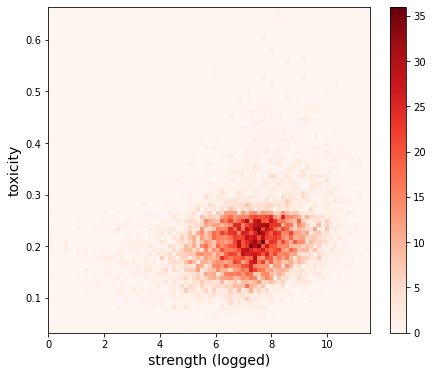

In [38]:
fig, ax = plt.subplots(figsize=(7.2,6))
x = nodedf[nodedf["gfp"]==1].dropna()["strength_logged"]
y = nodedf[nodedf["gfp"]==1].dropna()["mean_tox"]
plt.hist2d(x, y, (80,80), cmap="Reds")
plt.xlabel("strength (logged)", fontsize=14)
plt.ylabel("toxicity", fontsize=14)
plt.colorbar()
plt.savefig(ROOTPATH + f"output/fig/fpg2013.svg")

### does these toxic users cluster together?

**Visualization Problem**: too dense!

In [41]:
def build_filter(g):
    print("building filter...")
    return disparity_filter(g)
    
def cut_edge(g, alpha):
    g2 = nx.Graph()
    print("cutting edges...")
    for i,(u,v,d) in enumerate(g.edges(data=True)):
        if i%500000==0: print("progress:", i/len(g.edges()))
        if d["alpha"] < alpha:
            g2.add_edge(u,v,weight=d["weight"])
    return g2

In [42]:
userg2013 = build_filter(userg2013)
userg2013_small = cut_edge(userg2013, alpha=0.005)

building filter...
progress: 0.0
progress: 0.006790710308298248
progress: 0.013581420616596496
progress: 0.020372130924894743
progress: 0.027162841233192993
progress: 0.03395355154149124
progress: 0.040744261849789486
progress: 0.04753497215808774
progress: 0.054325682466385986
progress: 0.06111639277468423
progress: 0.06790710308298248
progress: 0.07469781339128073
progress: 0.08148852369957897
progress: 0.08827923400787722
progress: 0.09506994431617548
progress: 0.10186065462447372
progress: 0.10865136493277197
progress: 0.11544207524107021
progress: 0.12223278554936846
progress: 0.1290234958576667
progress: 0.13581420616596496
progress: 0.1426049164742632
progress: 0.14939562678256146
progress: 0.15618633709085972
progress: 0.16297704739915794
progress: 0.1697677577074562
progress: 0.17655846801575445
progress: 0.1833491783240527
progress: 0.19013988863235096
progress: 0.19693059894064918
progress: 0.20372130924894744
progress: 0.2105120195572457
progress: 0.21730272986554394
progre

In [43]:
def export_graph_csv(g, nodedf): 
    nodecsv = pd.DataFrame()
    nodecsv["Id"] = list(g.nodes())
    nodecsv["Label"] = nodecsv["Id"].map(lambda x: index2subr[x])
    nodecsv = nodecsv.merge(nodedf[["Id","mean_tox"]], on="Id", how="left")
    
    edgecsv = pd.DataFrame()
    sources = []
    targets = []
    weights = []
    for i,(u,v,d) in enumerate(g.edges(data=True)):
        sources.append(u)
        targets.append(v)
        weights.append(d["weight"])
    edgecsv["Source"] = sources
    edgecsv["Target"] = targets
    edgecsv["Weight"] = weights
    
    edgecsv.to_csv(ROOTPATH + "output/user_edge_2013.csv", index=False)
    nodecsv.to_csv(ROOTPATH + "output/user_node_2013.csv", index=False)
    return edgecsv, nodecsv

In [44]:
ec, nc = export_graph_csv(userg2013_small, nodedf)